##Importing dependencies

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.model_selection import train_test_split
from math import sqrt
import csv
import nltk
import math
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
from nltk import StanfordTagger
from sklearn.cluster import KMeans
import pickle
from urllib.request import urlopen
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


##Making csv of ingredient phrases

In [18]:
url = "https://raw.githubusercontent.com/amishaagg/RecipeDB-2.0/main/indian_cui_simp.csv"
df_recipe = pd.read_csv(url,encoding='latin1')
df_recipe

,title,description,cuisine,ingredients,servings,cook_time,steps
0,Spicy Tomato Semolina(Tomato Rava Upma),Semolina (also called Rava in India) tempered ...,Maharashtrian,4 tablespoons ghee (clarified butter) / butter...,4,11,[' Heat half of the ghee (clarified butter) in...
1,Savory Bread(Bread Upma),A unique and quick way of enjoying the humble ...,Indian,"6 big bread slices cut fine , 1 cups yoghurt b...",4,13,[' Soak the bread pieces in yoghurt for about ...
2,Quick Cream of Wheat Savory Cakes(Rava Idli),Semolina (also called Rava in India) tempered ...,Indian,"2 tablespoons coconut oil , 1 teaspoons mustar...",4,16,[' Heat the coconut oil in a pan. Toss in the ...
3,Savory Vermicelli(Sevaian Upma),Vermicelli (also called sevaian in India) subl...,Indian,2 tablespoons ghee (clarified butter) / butter...,4,10,[' Heat half of the ghee (clarified butter) in...
4,Savory Beaten Rice(Kaanda Poha),Beaten rice flakes(also called poha in India) ...,Maharashtrian,4 cups beaten rice flakes - thick variety (jaa...,4,8,[' Wash the beaten rice in water thoroughly. D...
...,...,...,...,...,...,...,...
98,Peanut Chutney(Kadale Chutney),Roasted peanuts ground with spices make an int...,Vegetarian,"2 tablespoons grated coconut , 2 tablespoons p...",4,2,[' Grind the coconut roasted peanuts green chi...
99,Onion Chutney(Pyaz ki Chutney),"Chutney is the Indian equivalent of a dip, and...",Vegetarian,"2 onions chopped ½ piece ginger chopped , 2 gr...",4,2,[' Grind the onions green chillies and ginger ...
100,Green Chutney(Hari Chutney),"Chutney is the Indian equivalent of a dip, and...",Vegetarian,"2 tablespoons grated coconut , 2 flakes garlic...",4,2,[' Grind the coconut onions cumin seeds green ...
101,Hot Spice Mix(Garam Masala),Keep this spice mix handy for it is used very ...,Indian,"100 grams (about 4 oz.), coriander seeds , 25 ...",Masala,0 Min,[' Dry roast all the ingredients (except dry g...


In [19]:
#set of ingredient phrases
set_ingredients=set()
for i in range(len(df_recipe)):
  ingredients=df_recipe['ingredients'][i]
  if(isinstance(ingredients, str)==False):
    print(type(ingredients))
    continue
  # print(type(ingredients))
  list_ingredients=ingredients.split(',')
  for ing in list_ingredients:
    set_ingredients.add(ing)

df=pd.DataFrame(set_ingredients)
df.columns=['Original']
df['Sentence']=df['Original']
df.to_csv('UniqueIngredientPhrase.csv')

#dataframe having the unique ingredient phrases
df=pd.read_csv('UniqueIngredientPhrase.csv')
df.head(10)

,Unnamed: 0,Original,Sentence
0,0,2 cups chickpea flour seived,2 cups chickpea flour seived
1,1,2 tablespoons butter / ghee (clarified butter)...,2 tablespoons butter / ghee (clarified butter)...
2,2,2 medium onions finely chopped,2 medium onions finely chopped
3,3,2 cups sprouted field beans (surti vaal dal),2 cups sprouted field beans (surti vaal dal)
4,4,4 dry red chillies broken,4 dry red chillies broken
5,5,1 teaspoons ginger chopped,1 teaspoons ginger chopped
6,6,2 tablespoons peanuts roasted,2 tablespoons peanuts roasted
7,7,4 cups mixed fruits chopped (pineapple,4 cups mixed fruits chopped (pineapple
8,8,salt and sugar to taste,salt and sugar to taste
9,9,salt and pepper to taste,salt and pepper to taste


##Convert to lowercase and convert chilli(es) to chilli


In [20]:
for i in df.index:
  df.at[i, 'Sentence'] = df.at[i, 'Sentence'].lower()
  sentence_tokens = (df.at[i, 'Sentence']).split()
  for j in range(len(sentence_tokens)):
    word=sentence_tokens[j]
    if(len(word)>4 and word[-4:]=='(es)'):
      sentence_tokens[j]=word[:-4]
  df.at[i,'Sentence']=' '.join(sentence_tokens)

df.head(10)

,Unnamed: 0,Original,Sentence
0,0,2 cups chickpea flour seived,2 cups chickpea flour seived
1,1,2 tablespoons butter / ghee (clarified butter)...,2 tablespoons butter / ghee (clarified butter)...
2,2,2 medium onions finely chopped,2 medium onions finely chopped
3,3,2 cups sprouted field beans (surti vaal dal),2 cups sprouted field beans (surti vaal dal)
4,4,4 dry red chillies broken,4 dry red chillies broken
5,5,1 teaspoons ginger chopped,1 teaspoons ginger chopped
6,6,2 tablespoons peanuts roasted,2 tablespoons peanuts roasted
7,7,4 cups mixed fruits chopped (pineapple,4 cups mixed fruits chopped (pineapple
8,8,salt and sugar to taste,salt and sugar to taste
9,9,salt and pepper to taste,salt and pepper to taste


##Removing Stop Words

In [21]:
stop_words = set(stopwords.words('english'))

for i in df.index:
    sentence_tokens = word_tokenize(df.at[i, 'Sentence'])
    sentence = ""
    for token in sentence_tokens:
        if token not in stop_words:
            sentence += token + " "
    df.at[i, 'Sentence'] = sentence

df

,Unnamed: 0,Original,Sentence
0,0,2 cups chickpea flour seived,2 cups chickpea flour seived
1,1,2 tablespoons butter / ghee (clarified butter)...,2 tablespoons butter / ghee ( clarified butter...
2,2,2 medium onions finely chopped,2 medium onions finely chopped
3,3,2 cups sprouted field beans (surti vaal dal),2 cups sprouted field beans ( surti vaal dal )
4,4,4 dry red chillies broken,4 dry red chillies broken
...,...,...,...
620,620,2 cups hot water or as required,2 cups hot water required
621,621,1 onions chopped,1 onions chopped
622,622,6 tablespoons ghee (clarified butter),6 tablespoons ghee ( clarified butter )
623,623,2 teaspoons lemon juice (optional),2 teaspoons lemon juice ( optional )


##Lemmatization


In [22]:
lemmatizer = WordNetLemmatizer()

for i in df.index:
  sentence_tokens = word_tokenize(df.at[i, 'Sentence'])
  # Lemmatize list of words and join
  lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in sentence_tokens])
  df.at[i, 'Sentence'] = lemmatized_output
df.head(10)


,Unnamed: 0,Original,Sentence
0,0,2 cups chickpea flour seived,2 cup chickpea flour seived
1,1,2 tablespoons butter / ghee (clarified butter)...,2 tablespoon butter / ghee ( clarified butter ...
2,2,2 medium onions finely chopped,2 medium onion finely chopped
3,3,2 cups sprouted field beans (surti vaal dal),2 cup sprouted field bean ( surti vaal dal )
4,4,4 dry red chillies broken,4 dry red chilli broken
5,5,1 teaspoons ginger chopped,1 teaspoon ginger chopped
6,6,2 tablespoons peanuts roasted,2 tablespoon peanut roasted
7,7,4 cups mixed fruits chopped (pineapple,4 cup mixed fruit chopped ( pineapple
8,8,salt and sugar to taste,salt sugar taste
9,9,salt and pepper to taste,salt pepper taste


##Stanford POS Tagger

In [23]:
tags=[]
for i in df.index:
  text_tok = nltk.word_tokenize(df.at[i, 'Sentence'])
  pos_tagged = nltk.pos_tag(text_tok)
  pos_tagged_sentence=""

  for word,word_class in pos_tagged:
      pos_tagged_sentence+=word + "_" + word_class+" "
  tags.append(pos_tagged_sentence)
df['POS tagging']=tags
df.head(10)

,Unnamed: 0,Original,Sentence,POS tagging
0,0,2 cups chickpea flour seived,2 cup chickpea flour seived,2_CD cup_NN chickpea_NN flour_NN seived_VBD
1,1,2 tablespoons butter / ghee (clarified butter)...,2 tablespoon butter / ghee ( clarified butter ...,2_CD tablespoon_NN butter_NN /_NNP ghee_NN (_(...
2,2,2 medium onions finely chopped,2 medium onion finely chopped,2_CD medium_NN onion_NN finely_RB chopped_VBD
3,3,2 cups sprouted field beans (surti vaal dal),2 cup sprouted field bean ( surti vaal dal ),2_CD cup_NN sprouted_VBD field_NN bean_NN (_( ...
4,4,4 dry red chillies broken,4 dry red chilli broken,4_CD dry_JJ red_JJ chilli_NN broken_NN
5,5,1 teaspoons ginger chopped,1 teaspoon ginger chopped,1_CD teaspoon_NN ginger_NN chopped_VBD
6,6,2 tablespoons peanuts roasted,2 tablespoon peanut roasted,2_CD tablespoon_NN peanut_NN roasted_VBD
7,7,4 cups mixed fruits chopped (pineapple,4 cup mixed fruit chopped ( pineapple,4_CD cup_NN mixed_JJ fruit_NN chopped_VBD (_( ...
8,8,salt and sugar to taste,salt sugar taste,salt_NN sugar_NN taste_NN
9,9,salt and pepper to taste,salt pepper taste,salt_NN pepper_IN taste_NN


##Storing tag frequency

In [24]:
def dumpPickleFile(data,filepath):
	pickle_out = open(filepath,"wb")
	print("Dumping the Pickle file into ",filepath,"...........")
	pickle.dump(data, pickle_out)
	print("Dumped the pickle File")
	pickle_out.close() 

def VectorFormat():
    #returns a dictionary of the form {'CC': 0, 'CD': 1, 'DT': 2, 'EX': 3, ..}
    data = urlopen('https://raw.githubusercontent.com/amishaagg/RecipeDB-2.0/main/tags_meaning')
    vector_format = {}
    count_var = 0
    for row in data:
        items = row.split()
        abbv = items[0]
        abbv=abbv.decode("latin1")
        vector_format[abbv] = count_var
        count_var += 1
    return vector_format
        
#VectorExample = "1_CD tablespoon_NN vegetable_NN oil_NN"
def make_vector(taggedLine,vector_format):
    #returns a vector showing which tag occurs how many times in a phrase
    #for example vec=[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    vector = [0]*len(vector_format)
    taggedWords = taggedLine.split(" ")
    for word in taggedWords:
        parts = word.split("_")
        tag='--'
        if(len(parts)==2):
          tag = parts[1]
        if tag  in vector_format:
            vector_position = vector_format[tag]
            vector[vector_position] += 1
    return vector


vector_dictionary = {}
vector_format = VectorFormat()
fullvector = []

#Storing the vector corresponding to each ingredient phrase
for i in df.index:
    sentenceID=df.at[i,"Unnamed: 0"]
    taggedSentence = df.at[i,"POS tagging"]
    vector = make_vector(taggedSentence,vector_format)
    vector_dictionary[sentenceID] = vector
    fullvector.append(vector)

dumpPickleFile(fullvector,"fullvector.pkl")


Dumping the Pickle file into  fullvector.pkl ...........
Dumped the pickle File


In [25]:
def loadPickleFile(filepath):
	print("Loading the pickle file from",filepath,"...........")
	pickle_in = open(filepath,"rb")
	example_dict = pickle.load(pickle_in)
	print("Loaded the pickle File")
	return example_dict

fullvector = loadPickleFile("fullvector.pkl")

Loading the pickle file from fullvector.pkl ...........
Loaded the pickle File


#K-means Clustering

Number of Clusters =  1
Inertia =  2022.8384000000012
-------------------------------------------------
Number of Clusters =  2
Inertia =  1336.804242630048
-------------------------------------------------
Number of Clusters =  3
Inertia =  1081.144498963385
-------------------------------------------------
Number of Clusters =  4
Inertia =  950.4914252822346
-------------------------------------------------
Number of Clusters =  5
Inertia =  857.3404616526996
-------------------------------------------------
Number of Clusters =  6
Inertia =  777.5166365874921
-------------------------------------------------
Number of Clusters =  7
Inertia =  734.5644266151944
-------------------------------------------------
Number of Clusters =  8
Inertia =  680.0098336668409
-------------------------------------------------
Number of Clusters =  9
Inertia =  636.4871789232612
-------------------------------------------------
Number of Clusters =  10
Inertia =  613.079707853353
-------------------

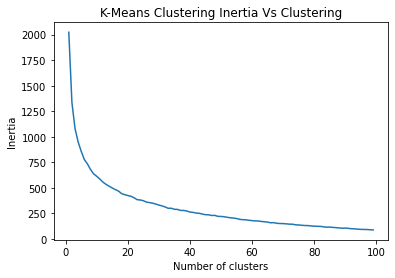

In [26]:
inertias = []
nfclustersarr = []

for nfclusters in range(1,100):
    kmeans = KMeans(n_clusters = nfclusters, random_state = 0).fit(fullvector)
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    inertias.append(inertia)
    nfclustersarr.append(nfclusters)
    print("Number of Clusters = ",nfclusters)
    print("Inertia = ",inertia)
    print("-------------------------------------------------")

plt.plot(nfclustersarr,inertias)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("K-Means Clustering Inertia Vs Clustering")
plt.show()

In [27]:
def doPCA(X,y = None,nfcomponents = 4):
    pca = PCA(n_components = nfcomponents)
    tran_X = pca.fit_transform(X,y)
    return pca,tran_X

vectorPCA,tran_X = doPCA(fullvector,labels,2)

#optimum number of clusters found through elbow method
nfclusters = 24
kmeans = KMeans(n_clusters = nfclusters, random_state = 0)
estimator=kmeans.fit(tran_X)

inertia = estimator.inertia_
labels = estimator.labels_
my_dict = {kmeans.cluster_centers_[i, 0]: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(labels,inertia)



[ 6 16  0 16  5  0  0 10  6  0  6  0  3  0  0 14 13 20  5  4 22 17  7  5
  1 17  7  5  9  6  0  0 10  4  3  0  4  4  7  5  1  0  6  6 17  2  5 20
  6  6  8 20  0  1 10  1  0  9  6  6  6  0 17  0 17  8  0  7  8  0  6  6
  0  6  4  1  4  4  0  4  0  0  4  6  8  7  4  4  8 10  7  6  0  9  4  6
  8  0 11  3  7  7  5  9  0  4 16  1 10  4  2  9  8  0  6 17  2  4 19  6
  4  7  8  8 16  0 22  6  4 22  6  6 23  7  0  0 17  6  6  7  6  6  6 10
  6  6  7 11  6 14  7 20  4  7 14  0  0  0  8 11  7 11  6  0  4  8 11  1
 10 21  2  4 11 15  4  7  4  7  8  6  4  0 12  8  8  2  7  7  3 10 23  6
  6  0  0  0  4  0  5  7  6 10  0 16  0  4  7 11  0  6  6 10  2  7  8 15
  0  4 21  3  0  0 22  1 17  0  6  0  6 14  6 11  5  5 22  5  0  5  0  2
  7  3  6  2  0 10  2  7  0  4 21  2  4  0  0  6  6  0  4  7  6  6  0  8
  0  7  7 10 14 11  6  7  0  1  6  6 17  8  1  6  5 17  7 11  0 17  6  7
  5  0  7  2  5  5  5  0  7 10 15  0 10  7  7  0 10  0  9  2  7 19  0  4
  2  0  0  0  6  7  4  8 10  0 17  0  4  0  2  9  6

In [28]:
#my_dict = {centroid1:[pt1,pt5,pt7], centroid2:[pt6,pt9,pt10,pt100],....}
set_centroid=set()
data_points=[]
for group in my_dict:
  set_centroid.add(group);
  lis=[]
  for ing in my_dict[group]:
    lis.append(df.at[ing,'Sentence'])
  data_points.append(lis)

df_cluster=pd.DataFrame(set_centroid)
df_cluster['Phrases']=data_points
df_cluster

,0,Phrases
0,-0.594348,"[2 medium onion finely chopped, 1 teaspoon gin..."
1,1.723989,"[½ teaspoon turmeric powder chilli powder, 1 c..."
2,-0.412822,"[1 teaspoon coriander-cumin powder, 4 cup chop..."
3,3.668512,[2 tablespoon chopped fresh coriander leaf oil...
4,-0.253447,"[2 cup uncooked rice, 2 red chilli broken bit,..."
5,0.417655,"[4 dry red chilli broken, 2 tomato cut thick l..."
6,1.402625,"[2 cup chickpea flour seived, salt sugar taste..."
7,0.568864,"[2 big tomato finely chopped, 1 large tomato c..."
8,1.574937,"[4 potato boiled, 1 teacup milk, 2 clove, pota..."
9,3.043611,[1 tablespoon finely chopped ground ginger gar...


#Test train split for NER tagging

In [29]:
#taking training phrases for each label
#if number of phrases is more than 10, then take 25% of data, else take entire data except one phrase
data_points=df_cluster['Phrases']
train_points=[]
for lis in data_points:
  length=len(lis)
  train=[]
  toTake=length/4
  if length<=10:
    toTake=length-2
  for i in range(math.floor(toTake)):
    train.append(lis[i])
  train_points.append(train)

myList=[*range(0,nfclusters,1)]
df_train=pd.DataFrame(myList)
df_train['Train Phrases']=train_points
df_train

,0,Train Phrases
0,0,"[2 medium onion finely chopped, 1 teaspoon gin..."
1,1,"[½ teaspoon turmeric powder chilli powder, 1 c..."
2,2,"[1 teaspoon coriander-cumin powder, 4 cup chop..."
3,3,[2 tablespoon chopped fresh coriander leaf oil...
4,4,"[2 cup uncooked rice, 2 red chilli broken bit,..."
5,5,"[4 dry red chilli broken, 2 tomato cut thick l..."
6,6,"[2 cup chickpea flour seived, salt sugar taste..."
7,7,"[2 big tomato finely chopped, 1 large tomato c..."
8,8,"[4 potato boiled, 1 teacup milk, 2 clove, pota..."
9,9,[1 tablespoon finely chopped ground ginger gar...


In [30]:
#taking testing phrases for each label
#if number of phrases is more than 10, then take 12.5% of data, else take only one phrase
data_points=df_cluster['Phrases']
test_points=[]
for lis in data_points:
  # lis = eval(lis)
  length=len(lis)
  test=[]
  a=math.floor(length/4+1)
  toTake=math.floor(a+length/10)
  if length<=10:
    a =  length-2
    toTake = length
  for i in range(a,math.floor(toTake)):
    test.append(lis[i])
  test_points.append(test)
i=0
for test in test_points:
  print(len(test),len(data_points[i]))
  i+=1

myList=[*range(0,nfclusters,1)]
df_test=pd.DataFrame(myList)
df_test['Test Phrases']=test_points
df_test

13 133
1 17
2 23
2 8
7 72
2 22
8 84
6 65
4 40
1 19
3 38
2 25
2 2
2 3
2 7
2 7
2 10
1 19
2 2
2 7
2 5
2 7
2 7
2 3


,0,Test Phrases
0,0,"[2 cup milk, 1 tablespoon finely chopped ginge..."
1,1,[1 teaspoon hot spice mix ( garam masala )]
2,2,"[4 whole green cardamom, 1 blade mace ( option..."
3,3,[pepper lemon juice taste . fresh coriander pa...
4,4,"[2 tablespoon chopped fresh coriander, chopped..."
5,5,"[½ cup hot water, 2 green chilli slit chopped ..."
6,6,"[2 tablespoon mint leaf finely chopped, 2 teas..."
7,7,"[4 large tomato finely chopped, 1 small onion ..."
8,8,"[salt, 100 gram ( 4 oz . ), 1 onion finely cho..."
9,9,[1 teaspoon cumin mustard seed]


In [31]:
writer = pd.ExcelWriter('train.xlsx')
df_train.to_excel(writer)
writer.save()
writer = pd.ExcelWriter('test.xlsx')
df_test.to_excel(writer)
writer.save()

In [32]:
def tokenise_phrase(train_points,saveAs):
  words=[]
  for train in train_points:
    for phrase in train:
      tokens=phrase.split(" ")
      for t in tokens:
        words.append(t)
      words.append(" ")
    words.append("___")       
  df_manual=pd.DataFrame(words)
  writer = pd.ExcelWriter(str(saveAs))
  df_manual.to_excel(writer)
  writer.save()

tokenise_phrase(train_points, 'annotate_train.xlsx')
tokenise_phrase(test_points, 'annotate_test.xlsx')